In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint, uniform
import joblib
import os
from sklearn.metrics import confusion_matrix, classification_report


### Functions for loading and ploting data 

In [2]:
def load_data(data_path):
    data = pd.read_csv(data_path)
    data["tI/2_Acetate"] = pd.to_numeric(data["tI/2_Acetate"], errors="coerce")
    data = data.dropna(subset=["tI/2_Acetate"])
    return data


def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 8))

    sns.set_style("white")

    plt.scatter(
        y_true,
        y_pred,
        color="purple",
        s=50,
        alpha=0.7,
        edgecolors="black",
        linewidth=0.5,
    )

    min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "k--", lw=2)

    plt.xlabel("Actual t1/2 Acetate", fontsize=10)
    plt.ylabel("Predicted t1/2 Acetate", fontsize=10)

    plt.tight_layout()
    plt.show()

### Linear regression for predicting polymer stability in tI/2_Acetate 

Root Mean Squared Error (RMSE): 4.5065
Mean Absolute Error (MAE): 3.5569
R-squared (R2) Score: 0.6167


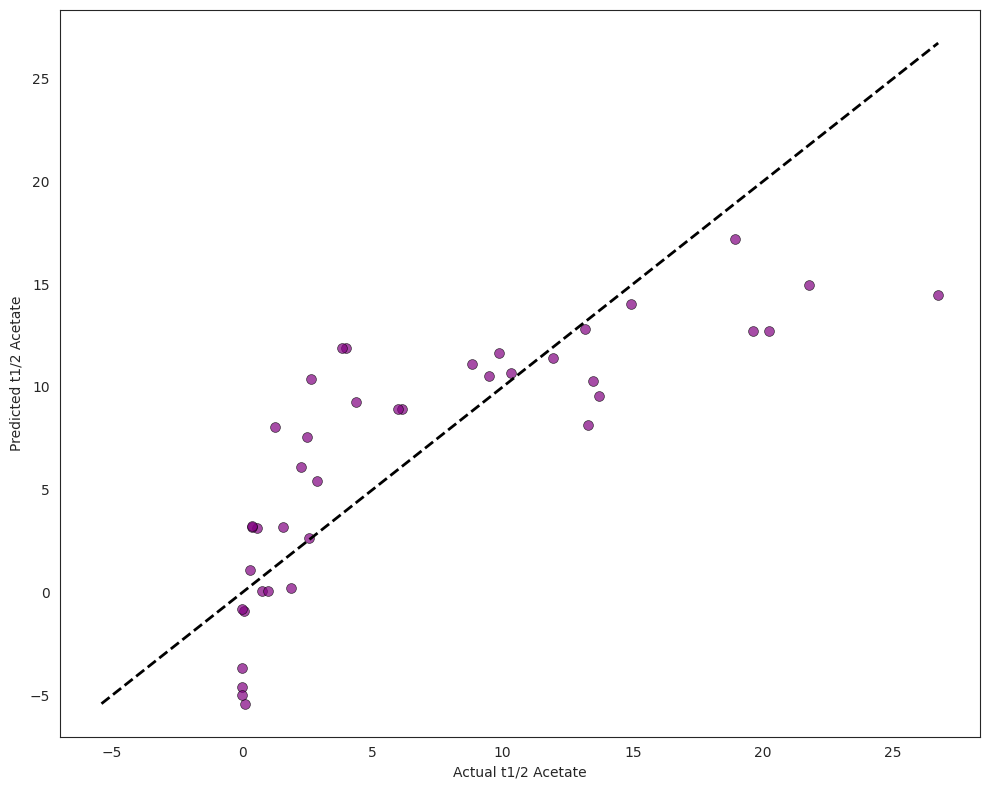

In [3]:
def main(data_path):
    # Load data
    data = load_data(data_path)
    X = data[["DS_acycl", "DS_cycl"]]
    y = data["tI/2_Acetate"]
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
    
    # Initialize LOOCV
    loo = LeaveOneOut()
    predictions = []
    
    # Perform LOOCV
    for train_index, test_index in loo.split(X_scaled_df):
        X_train, X_test = X_scaled_df.iloc[train_index], X_scaled_df.iloc[test_index]
        y_train = y.iloc[train_index]
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        
    
        pred = model.predict(X_test)
        predictions.append(pred[0])
    
    predictions = np.array(predictions)
    

    rmse = np.sqrt(mean_squared_error(y, predictions))
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2) Score: {r2:.4f}")
    
    plot_predictions(y, predictions)

if __name__ == "__main__":
    data_path = "/home/ta45woj/PolyNanoStabML/data/nano_polymer_stability.csv"
    main(data_path)

### Hyperparameter tuning for Gradient Boosting Regressor

In [4]:
# load data
data = load_data(data_path)

X = data[["DS_acycl", "DS_cycl"]]

y = data["tI/2_Acetate"]

loo = LeaveOneOut()

num_seeds = 10
seeds = range(10, 10 + num_seeds)

mean_maes = []

all_predictions = {i: [] for i in range(len(y))}

best_params = None

for seed in seeds:
    actual_values = []
    predicted_values = []
    mae_list = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # Define the hyperparameter distributions
        param_distributions = {
            "n_estimators": randint(10, 51),
            "learning_rate": uniform(0.05, 0.21),
            "max_depth": randint(2, 6),
        }
        # Create the model
        model = GradientBoostingRegressor(random_state=seed)
        search = RandomizedSearchCV(
            model,
            param_distributions=param_distributions,
            n_iter=10,
            scoring="neg_mean_absolute_error",
            cv=5,
            random_state=seed,
            n_jobs=-1,
        )

        search.fit(X_train, y_train)

        best_model = search.best_estimator_

        best_params = search.best_params_

        y_pred = best_model.predict(X_test)
        actual_value = y_test.values[0]
        predicted_value = y_pred[0]
        actual_values.append(actual_value)
        predicted_values.append(predicted_value)

        all_predictions[test_index[0]].append(predicted_value)

        mae = mean_absolute_error([actual_value], [predicted_value])
        mae_list.append(mae)

    mean_mae = np.mean(mae_list)
    mean_maes.append(mean_mae)


overall_mean_mae = np.mean(mean_maes)
overall_std_mae = np.std(mean_maes)

std_devs = [np.std(all_predictions[i]) for i in range(len(y))]

print(f"Mean Absolute Error (MAE): {overall_mean_mae:.4f} ± {overall_std_mae:.4f}")

# Print the best parameters
print("\nBest Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Mean Absolute Error (MAE): 1.7151 ± 0.0751

Best Parameters:
learning_rate: 0.25637580205428495
max_depth: 2
n_estimators: 49


### Gradient Boosting Regressor with hyperparameters tuned

Training model for sample 0
Training model for sample 1
Training model for sample 2
Training model for sample 3
Training model for sample 4
Training model for sample 5
Training model for sample 6
Training model for sample 7
Training model for sample 8
Training model for sample 9
Training model for sample 10
Training model for sample 11
Training model for sample 12
Training model for sample 13
Training model for sample 14
Training model for sample 15
Training model for sample 16
Training model for sample 17
Training model for sample 18
Training model for sample 19
Training model for sample 20
Training model for sample 21
Training model for sample 22
Training model for sample 23
Training model for sample 24
Training model for sample 25
Training model for sample 26
Training model for sample 27
Training model for sample 28
Training model for sample 29
Training model for sample 30
Training model for sample 31
Training model for sample 32
Training model for sample 33
Training model for sampl

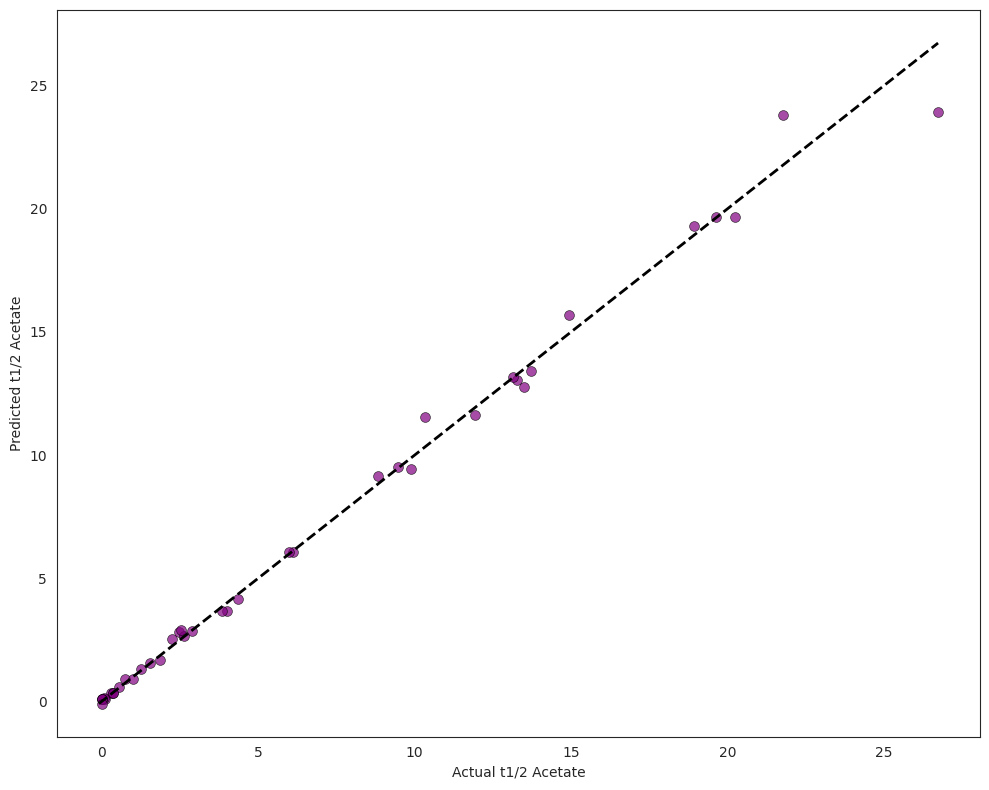

In [6]:
def train_and_save_model(X_train, y_train, sample_index):
    model = GradientBoostingRegressor(
        n_estimators=49,
        learning_rate=0.25637580205428495,
        max_depth=2,
        random_state=42,
    )
    model.fit(X_train, y_train)

    model_filename = f"regression_models/model_sample{sample_index}.joblib"
    joblib.dump(model, model_filename)


def load_model_and_predict(X_test, sample_index):
    model_filename = f"regression_models/model_sample{sample_index}.joblib"
    model = joblib.load(model_filename)
    return model.predict(X_test)[0]


def calculate_stats(predictions):
    mean_predictions = np.mean(predictions, axis=1)
    std_predictions = np.std(predictions, axis=1)
    return mean_predictions, std_predictions


def main(data_path):
    data = load_data(data_path)
    X = data[["DS_acycl", "DS_cycl"]]
    y = data["tI/2_Acetate"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    loo = LeaveOneOut()

    # Create a directory to store models
    os.makedirs("regression_models", exist_ok=True)

    all_predictions = {i: [] for i in range(len(y))}

    # Train models
    for i, (train_index, test_index) in enumerate(loo.split(X_scaled_df)):
        print(f"Training model for sample {i}")
        X_train, X_test = X_scaled_df.iloc[train_index], X_scaled_df.iloc[test_index]
        y_train = y.iloc[train_index]

        # Train and save the model
        train_and_save_model(X_train, y_train, i)

    # Make predictions using all models except the one trained on the test point
    for i in range(len(X_scaled_df)):
        print(f"Predicting for sample {i}")
        X_test = X_scaled_df.iloc[[i]]
        predictions = []
        for j in range(len(X_scaled_df)):
            if i != j:  # Don't use the model trained on this sample
                pred = load_model_and_predict(X_test, j)
                predictions.append(pred)
        all_predictions[i] = predictions

    mean_predictions, std_predictions = calculate_stats(
        np.array(list(all_predictions.values()))
    )

    rmse = np.sqrt(mean_squared_error(y, mean_predictions))
    mae = mean_absolute_error(y, mean_predictions)

    mae_std = np.std(
        [
            mean_absolute_error([y.iloc[i]], [pred])
            for i, pred in enumerate(mean_predictions)
        ]
    )

    r2 = r2_score(y, mean_predictions)

    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f} ± {mae_std:.4f}")
    print(f"R-squared (R2) Score: {r2:.4f}")

    plot_predictions(y, mean_predictions)


if __name__ == "__main__":
    data_path = "/home/ta45woj/PolyNanoStabML/data/nano_polymer_stability.csv"
    main(data_path)


### Classification of polymer stability in tI/2_PBS

/home/ta45woj/miniconda3/envs/polyspeck/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


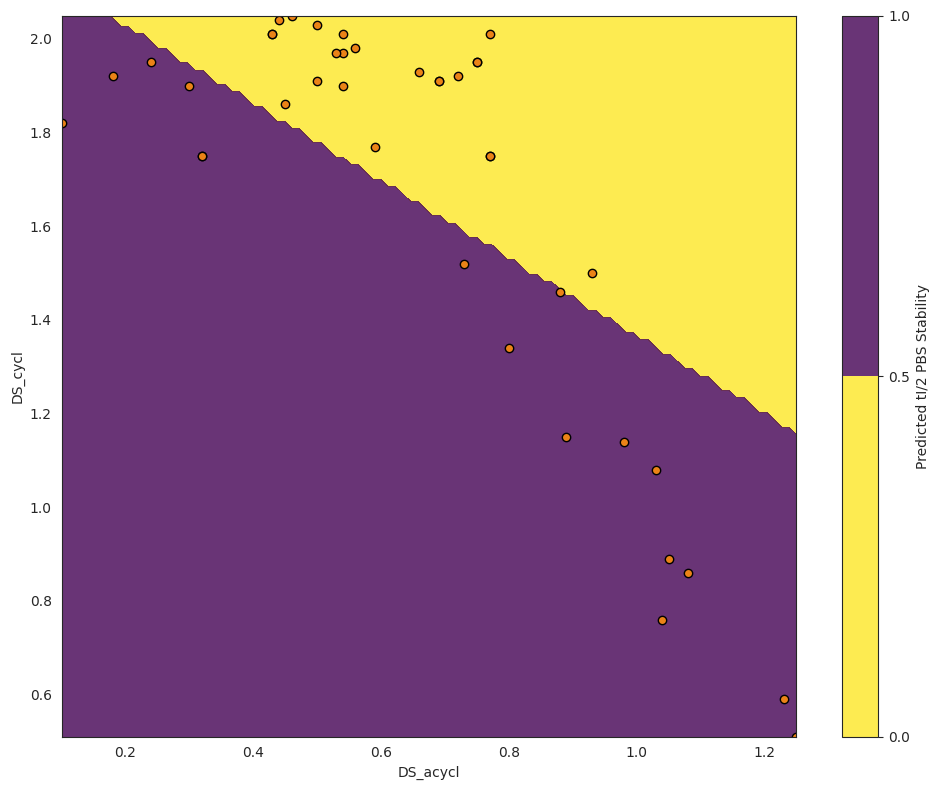

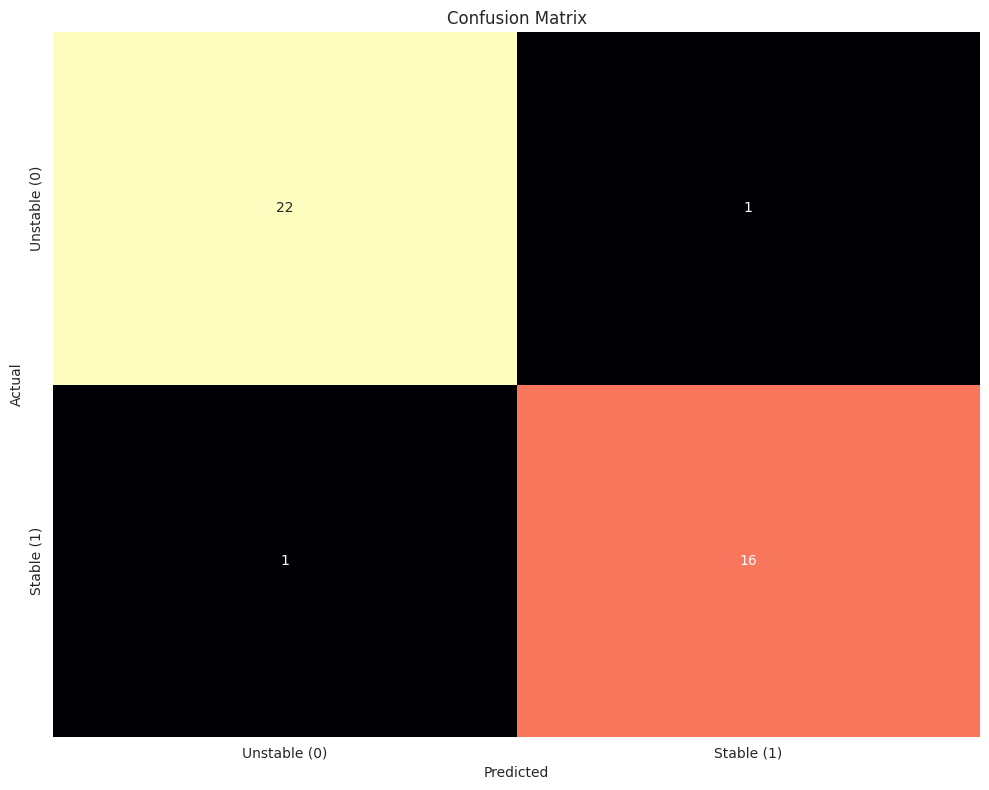


Classification Report:
              precision    recall  f1-score   support

      stable       0.96      0.96      0.96        23
    unstable       0.94      0.94      0.94        17

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



In [10]:
def plot_decision_boundary(X, y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = LogisticRegression(class_weight="balanced", random_state=42)
    model.fit(X_scaled, y_encoded)

    plt.figure(figsize=(10, 8))
    x_range = np.linspace(X["DS_acycl"].min(), X["DS_acycl"].max(), 100)
    y_range = np.linspace(X["DS_cycl"].min(), X["DS_cycl"].max(), 100)
    xx, yy = np.meshgrid(x_range, y_range)

    Z = model.predict(scaler.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

    contour = plt.contourf(
        xx, yy, Z, levels=1, colors=["#fde725", "#440154"], alpha=0.8
    )

    plt.scatter(X["DS_acycl"], X["DS_cycl"], color="#EB8317", edgecolor="black")

    plt.xlabel("DS_acycl")
    plt.ylabel("DS_cycl")
    plt.colorbar(contour, label="Predicted tI/2 PBS Stability")
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(X, y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = LogisticRegression(class_weight="balanced", random_state=42)
    model.fit(X_scaled, y_encoded)

    y_pred = model.predict(X_scaled)

    cm = confusion_matrix(y_encoded, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="magma", cbar=False)

    tick_labels = ["Unstable (0)", "Stable (1)"]
    plt.xticks([0.5, 1.5], tick_labels)
    plt.yticks([0.5, 1.5], tick_labels, rotation=90)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y, le.inverse_transform(y_pred)))


# Load and process data
data = pd.read_csv(
    "/home/ta45woj/PolyNanoStabML/data/nano_polymer_stability.csv"
)
data["tI/2_Acetate"] = pd.to_numeric(data["tI/2_Acetate"], errors="coerce")
data = data.dropna(subset=["tI/2_Acetate"])

X = data[["DS_acycl", "DS_cycl"]]
y_pbs = data["tI/2_PBS"]

plot_decision_boundary(X, y_pbs)

plot_confusion_matrix(X, y_pbs)